# CF - Compliance

## Package Setup

In [ ]:
!wget -nc ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2/sst.wkmean.1981-1989.nc
!apt install libudunits2-dev libnetcdff-dev netcdf-bin
!pip install cfchecker

In [ ]:
import xarray as xr

def check_output(dataset, **to_netcdf_kwargs):
    import tempfile
    with tempfile.NamedTemporaryFile(suffix='.nc') as f:
        dataset.to_netcdf(f.name, **to_netcdf_kwargs)
        !cfchecks -v 1.0 {f.name}

## Fake data from scratch:

In [ ]:
import pandas as pd
import numpy as np
def create_psuedo_data(ntime=5, nlat=10, nlon=10):
    data = 283 + 5 * np.random.rand(ntime, nlat, nlon)

    array = xr.DataArray(
            data,
            coords={
                'time': pd.date_range('2021-01-01', periods=ntime),
                'latitude': np.linspace(10, 30, nlat),
                'longitude': np.linspace(-100, -80, nlon, endpoint=False)
            },
            dims=['time', 'latitude', 'longitude'])
    
    # array.attrs['units'] = 'kelvin'
    # array.attrs['standard_name'] = 'air_temperature'
    # array['latitude'].attrs['units'] = 'degrees_north'
    # array['latitude'].attrs['long_name'] = 'latitude'
    # array['longitude'].attrs['units'] = 'degrees_east'
    # array['longitude'].attrs['long_name'] = 'longitude'
    # array['time'].attrs['long_name'] = 'time'
    return array

test_array = create_psuedo_data()
# test_array.name = "made_up_data"
test_array.to_netcdf('test.nc')
!cfchecks test.nc

CHECKING NetCDF FILE: test.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.8
Using Standard Name Table Version 77 (2021-01-19T13:38:50Z)
Using Area Type Table Version 10 (23 June 2020)
Using Standardized Region Name Table Version 4 (18 December 2018)

WARN: (2.6.1): No 'Conventions' attribute present

------------------
Checking variable: time
------------------

------------------
Checking variable: latitude
------------------

------------------
Checking variable: longitude
------------------

------------------
Checking variable: made_up_data
------------------

ERRORS detected: 0
WARNINGS given: 1
INFORMATION messages: 0


## Processed Data From CF-Compliant Source

xarray will read in and attach all attributes to the dataset / dataarray from netcdf/hdf and decoded metadata from grib. 

In [ ]:
local_filepath = 'sst.wkmean.1981-1989.nc'
with xr.open_dataset(local_filepath) as f:
    print(f)
    print(f['sst'])
    print(f['lat'])
    print(f['lon'])

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 427)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-10-29 1981-11-05 ... 1989-12-28
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    sst        (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.n

In [ ]:
!cfchecks -v 1.0 {local_filepath}

CHECKING NetCDF FILE: sst.wkmean.1981-1989.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.0
Using Standard Name Table Version 77 (2021-01-19T13:38:50Z)
Using Standardized Region Name Table Version 4 (18 December 2018)


------------------
Checking variable: lat
------------------

------------------
Checking variable: lon
------------------

------------------
Checking variable: time
------------------
WARN: (4.4.1): Use of the calendar and/or month_lengths attributes is recommended for time coordinate variables

------------------
Checking variable: time_bnds
------------------

------------------
Checking variable: sst
------------------

ERRORS detected: 0
WARNINGS given: 1
INFORMATION messages: 0


When data is processed however, attributes will be dropped (they likely no longer apply; similar to NCL functions without `copyVarMeta`)

In [ ]:
with xr.open_dataset(local_filepath) as f:
    annual_means = f['sst'].resample({'time':'1Y'}).mean()

unaltered coordinates will still look the same though. 

In [ ]:
print(annual_means, end="\n\n\n")

print(annual_means['time'], end="\n\n\n")
print(annual_means['lat'], end="\n\n\n")
print(annual_means['lon'], end="\n\n\n")

<xarray.DataArray 'sst' (time: 9, lat: 180, lon: 360)>
array([[[-1.8      , -1.8      , -1.8      , ..., -1.8      ,
         -1.8      , -1.8      ],
        [-1.8      , -1.8      , -1.8      , ..., -1.8      ,
         -1.8      , -1.8      ],
        [-1.7800003, -1.7800003, -1.7800003, ..., -1.7889999,
         -1.7889999, -1.7880001],
        ...,
        [-1.8      , -1.8      , -1.8      , ..., -1.8      ,
         -1.8      , -1.8      ],
        [-1.8      , -1.8      , -1.8      , ..., -1.8      ,
         -1.8      , -1.8      ],
        [-1.8      , -1.8      , -1.8      , ..., -1.8      ,
         -1.8      , -1.8      ]],

       [[-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,
         -1.8000005, -1.8000005],
        [-1.7778847, -1.7773077, -1.7775002, ..., -1.7848083,
         -1.7848083, -1.7851927],
...
        [-1.8000005, -1.8000005, -1.8000005, ..., -1.8000005,


In [ ]:
annual_means.to_netcdf('sst.annmean.1981-1989.nc')

In [ ]:
!cfchecks -v 1.0 sst.annmean.1981-1989.nc

CHECKING NetCDF FILE: sst.annmean.1981-1989.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.0
Using Standard Name Table Version 77 (2021-01-19T13:38:50Z)
Using Standardized Region Name Table Version 4 (18 December 2018)

WARN: (2.6.1): No 'Conventions' attribute present

------------------
Checking variable: time
------------------
WARN: (3): No standard_name or long_name attribute specified

------------------
Checking variable: lat
------------------
INFO: attribute _FillValue is being used in a non-standard way

------------------
Checking variable: lon
------------------
INFO: attribute _FillValue is being used in a non-standard way

------------------
Checking variable: sst
------------------
WARN: (3): No standard_name or long_name attribute specified
INFO: (3.1): No units attribute set.  Please consider adding a units attribute for completeness.

ERRORS detected: 0
WARNINGS given: 3
INFORMATION messages: 3


In [ ]:
print(annual_means['time'].attrs)
print(annual_means.attrs)

{}
{}


NetCDF metdata is attached in the `.attrs` dict per `DataArray`.  These can be manipulated like generic python `dicts`.

To set global attributes, convert to a dataset and add metadata to the `Dataset` these will become global attributes in the netcdf. 

*aside, xarray adds `_FillValue` to all `DataArray` older cf version don't like this.  It can be turned of with `None` settings.  Newer cf versions are ok with _FillValues in coordinates.

In [ ]:
annual_mean_ds = annual_means.to_dataset()

annual_mean_ds.attrs['Conventions'] = 'CF-1.0'

annual_mean_ds['sst'].attrs['long_name'] = 'Annual Mean Sea Surface Temperature'
annual_mean_ds['sst'].attrs.update({'units':'K'})
annual_mean_ds['time'].attrs = {'long_name':'time'}

check_output(annual_mean_ds, encoding={'lat': {'_FillValue':None}, 'lon': {'_FillValue':None}})

CHECKING NetCDF FILE: /tmp/tmpgbhsdmtq.nc
Using CF Checker Version 4.1.0
Checking against CF Version CF-1.0
Using Standard Name Table Version 77 (2021-01-19T13:38:50Z)
Using Standardized Region Name Table Version 4 (18 December 2018)


------------------
Checking variable: time
------------------

------------------
Checking variable: lat
------------------

------------------
Checking variable: lon
------------------

------------------
Checking variable: sst
------------------

ERRORS detected: 0
WARNINGS given: 0
INFORMATION messages: 0


In [ ]:
annual_mean_ds.to_netcdf('sst.annmean.1981-1989.nc', encoding={'lat': {'_FillValue':None}, 'lon': {'_FillValue':None}})
!ncdump -sh sst.annmean.1981-1989.nc

netcdf sst.annmean.1981-1989 {
dimensions:
	time = 9 ;
	lat = 180 ;
	lon = 360 ;
variables:
	int64 time(time) ;
		time:long_name = "time" ;
		time:units = "days since 1981-12-31 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "contiguous" ;
		time:_Endianness = "little" ;
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
		lat:actual_range = 89.5f, -89.5f ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:coordinate_defines = "center" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.5f, 359.5f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:coordinate_defines = "center" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	float sst(time, lat, lon) ;
		sst:_FillValue = NaNf ;
		sst:long_name = "Annual Mean Sea Surface Temperature" ;
		sst:units = "K" ;
		sst:_Storage = "contig

Each variable can be compressed and netcdf chunksizes can be manually assigned (or automatically decided)

In [ ]:
compression = {"zlib": True, "complevel": 1, 'chunksizes':(1,90, 180)}
encoding={'lat': {'_FillValue': None}, 'lon': {'_FillValue': None }, 'sst':compression}

annual_mean_ds.to_netcdf('sst.annmean.1981-1989.nc', encoding=encoding)

!ncdump -sh sst.annmean.1981-1989.nc
!ls -lh sst.annmean.1981-1989.nc

netcdf sst.annmean.1981-1989 {
dimensions:
	time = 9 ;
	lat = 180 ;
	lon = 360 ;
variables:
	int64 time(time) ;
		time:long_name = "time" ;
		time:units = "days since 1981-12-31 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "contiguous" ;
		time:_Endianness = "little" ;
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
		lat:actual_range = 89.5f, -89.5f ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:coordinate_defines = "center" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.5f, 359.5f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:coordinate_defines = "center" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	float sst(time, lat, lon) ;
		sst:_FillValue = NaNf ;
		sst:long_name = "Annual Mean Sea Surface Temperature" ;
		sst:units = "K" ;
		sst:_Storage = "chunke

At this time xarray can append to a netcdf file, can overwrite a variable but does not support appending to an existing variable along an unlimited dim.  
https://github.com/pydata/xarray/issues/1672

#Reading Multiple Files

In [ ]:
!wget -q -nc ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2/sst.wkmean.1990-present.nc

In [ ]:
multi_dataset = xr.open_mfdataset(['sst.wkmean.1981-1989.nc', 'sst.wkmean.1990-present.nc'], )
print(multi_dataset)

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 2068)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-10-29 1981-11-05 ... 2021-06-06
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(427, 2), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(427, 180, 360), meta=np.ndarray>
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....

In [ ]:
compression = {"zlib": True, "complevel": 1, 'chunksizes':(1,90, 180)}
encoding={'lat': {'_FillValue': None}, 'lon': {'_FillValue': None }, 'sst':compression}


annual_means = multi_dataset['sst'].resample({'time':'1Y'}).mean()
annual_means.attrs = multi_dataset['sst'].attrs


annual_mean_ds = annual_means.to_dataset()
annual_mean_ds.attrs['Conventions'] = 'CF-1.0'

annual_mean_ds['sst'].attrs['long_name'] = 'Annual Mean Sea Surface Temperature'
annual_mean_ds['sst'].attrs['_FillValue'] = netCDF4.default_fillvals['f8']
annual_mean_ds['time'].attrs = {'long_name':'time'}

annual_mean_ds.to_netcdf('sst.annmean.1981-present.nc', encoding=encoding)

In [ ]:
!ncdump -sh sst.annmean.1981-present.nc
!ls -lh sst.annmean.1981-present.nc

netcdf sst.annmean.1981-present {
dimensions:
	time = 41 ;
	lat = 180 ;
	lon = 360 ;
variables:
	int64 time(time) ;
		time:long_name = "time" ;
		time:units = "days since 1981-12-31 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "contiguous" ;
		time:_Endianness = "little" ;
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
		lat:actual_range = 89.5f, -89.5f ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:coordinate_defines = "center" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.5f, 359.5f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:coordinate_defines = "center" ;
		lon:_Storage = "contiguous" ;
		lon:_Endianness = "little" ;
	float sst(time, lat, lon) ;
		sst:_FillValue = 9.96921e+36f ;
		sst:long_name = "Annual Mean Sea Surface Temperature" ;
		sst:unpacked_valid_range = -5.

# Reading HDF Files

In [ ]:
!rm -rf sst-h5*
!wget -nc http://atmet.com/data/sst-h5.tar.gz
!tar -xvzf sst-h5.tar.gz

--2021-06-17 23:49:48--  http://atmet.com/data/sst-h5.tar.gz
Resolving atmet.com (atmet.com)... 64.71.34.67
Connecting to atmet.com (atmet.com)|64.71.34.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1124545 (1.1M) [application/x-gzip]
Saving to: ‘sst-h5.tar.gz’

sst-h5.tar.gz       100%[===================>]   1.07M  --.-KB/s    in 0.1s    

2021-06-17 23:49:48 (7.19 MB/s) - ‘sst-h5.tar.gz’ saved [1124545/1124545]

sst-h5/
sst-h5/SHEADER
sst-h5/SAPR90S000E.h5
sst-h5/SAPR90S180W.h5
sst-h5/SAUG90S000E.h5
sst-h5/SAUG90S180W.h5
sst-h5/SDEC90S000E.h5
sst-h5/SDEC90S180W.h5
sst-h5/SFEB90S000E.h5
sst-h5/SFEB90S180W.h5
sst-h5/SJAN90S000E.h5
sst-h5/SJAN90S180W.h5
sst-h5/SJUL90S000E.h5
sst-h5/SJUL90S180W.h5
sst-h5/SJUN90S000E.h5
sst-h5/SJUN90S180W.h5
sst-h5/SMAR90S000E.h5
sst-h5/SMAR90S180W.h5
sst-h5/SMAY90S000E.h5
sst-h5/SMAY90S180W.h5
sst-h5/SNOV90S000E.h5
sst-h5/SNOV90S180W.h5
sst-h5/SOCT90S000E.h5
sst-h5/SOCT90S180W.h5
sst-h5/SSEP90S000E.h5
sst-h5/SSEP90S180W.h5


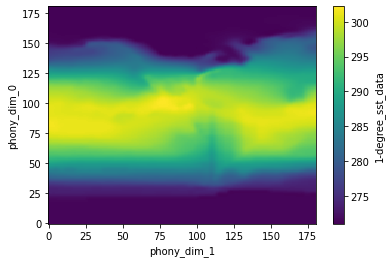

In [ ]:
filepath = 'sst-h5/SAPR90S180W.h5'
with xr.open_dataset(filepath) as ds:
    sst = ds['1-degree_sst_data']

sst.plot()

# Reading GRIB Files

In [ ]:
# Needs conda or more patience than I have to make work in colab
# but  would be
xr.open_dataset('some_grib.grib', engine='pygrib')  # pygrib backend
xr.open_dataset('some_grib.grib', engine='cfgrib')  # little less intuitive usage  # both use eccodes 

# Reading Grouped NetCDF data

In [ ]:
!wget rammb-data.cira.colostate.edu/~abrammer/cseg_data/grouped_netcdf_eg.nc

--2021-06-18 15:04:16--  http://rammb-data.cira.colostate.edu/~abrammer/cseg_data/grouped_netcdf_eg.nc
Resolving rammb-data.cira.colostate.edu (rammb-data.cira.colostate.edu)... 129.82.109.10
Connecting to rammb-data.cira.colostate.edu (rammb-data.cira.colostate.edu)|129.82.109.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28720 (28K) [application/octet-stream]
Saving to: ‘grouped_netcdf_eg.nc’

grouped_netcdf_eg.n 100%[===================>]  28.05K  --.-KB/s    in 0.04s   

2021-06-18 15:04:16 (643 KB/s) - ‘grouped_netcdf_eg.nc’ saved [28720/28720]



In [ ]:
import xarray as xr
print(xr.open_dataset('grouped_netcdf_eg.nc',))


<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.7


In [ ]:
import netCDF4
ncf = netCDF4.Dataset('grouped_netcdf_eg.nc')
print(ncf.groups)

{'Metadata': <class 'netCDF4._netCDF4.Group'>
group /Metadata:
    dimensions(sizes): 
    variables(dimensions): float64 AbscoCH4Scale(OneOff, Band), float64 AbscoCO2Scale(OneOff, Band), float64 AbscoCOScale(OneOff, Band), <class 'str'> AbscoFileCH4(OneOff), <class 'str'> AbscoFileCO(OneOff), <class 'str'> AbscoFileCO2(OneOff), <class 'str'> AbscoFileH2O(OneOff), <class 'str'> AbscoFileO2(OneOff), float64 AbscoH2OScale(OneOff, Band), float64 AbscoO2Scale(OneOff, Band), <class 'str'> AerosolFile(OneOff), <class 'str'> AllAerosolTypes(OneOff, AllAerosolTypes), <class 'str'> EOFFile(OneOff), <class 'str'> IMAPFile(OneOff), <class 'str'> L1BFile(OneOff), <class 'str'> MerraFile(OneOff), <class 'str'> ResampledMetFile(OneOff), int32 RetrievalIterationLimit(), <class 'str'> SolarFile(OneOff), <class 'str'> StaticInput(OneOff), float64 VMRO2()
    groups: , 'RetrievalResults': <class 'netCDF4._netCDF4.Group'>
group /RetrievalResults:
    dimensions(sizes): 
    variables(dimensions): <class 

In [ ]:
print(xr.open_dataset('grouped_netcdf_eg.nc', group='Metadata'))

MissingDimensionsError: ignored

In [ ]:
print(xr.open_dataset('grouped_netcdf_eg.nc', group='Metadata', drop_variables='AllAerosolTypes'))
print(xr.open_dataset('grouped_netcdf_eg.nc', group='RetrievalResults'))
print(xr.open_dataset('grouped_netcdf_eg.nc', group='RetrievedStateVector'))
print(xr.open_dataset('grouped_netcdf_eg.nc', group='SpectralParameters'))

<xarray.Dataset>
Dimensions:                  (Band: 4, OneOff: 1)
Dimensions without coordinates: Band, OneOff
Data variables: (12/20)
    AbscoCH4Scale            (OneOff, Band) float64 ...
    AbscoCO2Scale            (OneOff, Band) float64 ...
    AbscoCOScale             (OneOff, Band) float64 ...
    AbscoFileCH4             (OneOff) object ...
    AbscoFileCO              (OneOff) object ...
    AbscoFileCO2             (OneOff) object ...
    ...                       ...
    MerraFile                (OneOff) object ...
    ResampledMetFile         (OneOff) object ...
    RetrievalIterationLimit  int32 ...
    SolarFile                (OneOff) object ...
    StaticInput              (OneOff) object ...
    VMRO2                    float64 ...
<xarray.Dataset>
Dimensions:        (AllAerosolTypes: 8, OneOff: 1)
Dimensions without coordinates: AllAerosolTypes, OneOff
Data variables:
    aerosol_model  (OneOff, AllAerosolTypes) object ...
<xarray.Dataset>
Dimensions:             (O

In [ ]:
!wget -q -nc rammb-data.cira.colostate.edu/~abrammer/cseg_data/grouped_netcdf_eg2.nc
print(xr.open_dataset('grouped_netcdf_eg2.nc',))

<xarray.Dataset>
Dimensions:                (sounding_dim: 166110, vertex_dim: 4)
Dimensions without coordinates: sounding_dim, vertex_dim
Data variables: (12/15)
    Delta_Time             (sounding_dim) datetime64[ns] ...
    SZA                    (sounding_dim) float32 ...
    VZA                    (sounding_dim) float32 ...
    SAz                    (sounding_dim) float32 ...
    VAz                    (sounding_dim) float32 ...
    Longitude              (sounding_dim) float32 ...
    ...                     ...
    SIF_740nm              (sounding_dim) float32 ...
    SIF_Uncertainty_740nm  (sounding_dim) float32 ...
    Daily_SIF_740nm        (sounding_dim) float32 ...
    Daily_SIF_757nm        (sounding_dim) float32 ...
    Daily_SIF_771nm        (sounding_dim) float32 ...
    Quality_Flag           (sounding_dim) float32 ...
Attributes: (12/31)
    References:                        ['Sun, Y. et al., Remote Sensing of En...
    conventions:                       CF-1.6
   

In [ ]:
!ncdump -c grouped_netcdf_eg2.nc

netcdf grouped_netcdf_eg2 {
dimensions:
	footprint_dim = 8 ;
	signalbin_dim = 227 ;
	sounding_dim = 166110 ;
	statistics_dim = 2 ;
	vertex_dim = 4 ;
variables:
	double Delta_Time(sounding_dim) ;
		Delta_Time:least_significant_digit = 2LL ;
		Delta_Time:long_name = "Time" ;
		Delta_Time:units = "seconds since 1990-01-01 00:00:00 UTC" ;
		Delta_Time:scale_factor = 1. ;
		Delta_Time:add_offset = 0. ;
		Delta_Time:missing_value = -999. ;
		Delta_Time:valid_range = 0., 1.e+30 ;
		Delta_Time:description = "Timestamp (seconds since 1 January 1990)" ;
	float SZA(sounding_dim) ;
		SZA:least_significant_digit = 4LL ;
		SZA:long_name = "Solar Zenith Angle" ;
		SZA:units = "degrees" ;
		SZA:scale_factor = 1.f ;
		SZA:add_offset = 0.f ;
		SZA:missing_value = -9.e+30f ;
		SZA:valid_range = 0.f, 90.f ;
		SZA:description = "Solar zenith angle is the angle between the line of sight to the sun and the local vertical" ;
	float VZA(sounding_dim) ;
		VZA:least_significant_digit = 4LL ;
		VZA:long_name = "V

In [ ]:
import xarray as xr
science_ds = xr.open_dataset('grouped_netcdf_eg2.nc', group='Science')
for var in science_ds:
    print(var)


sounding_qual_flag
IGBP_index
continuum_radiance_757nm
SIF_757nm
SIF_Unadjusted_757nm
SIF_Relative_757nm
SIF_Unadjusted_Relative_757nm
SIF_Uncertainty_757nm
continuum_radiance_771nm
SIF_771nm
SIF_Unadjusted_771nm
SIF_Relative_771nm
SIF_Unadjusted_Relative_771nm
SIF_Uncertainty_771nm
daily_correction_factor
sounding_land_fraction
